In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
# from rl2.model import RL2, MetaLearner
# from evaluate import evaluate_1d, evaluate_metalearner
import torch.nn.utils.rnn as rnn_utils
import numpy as np
FONTSIZE=20
import pandas as pd
import seaborn as sns

## Evaluate meta-learner on Johannsen task

In [179]:
data = pd.read_csv('../data/meta_learner/johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_beta=0.3_num_trials=288_num_runs=1.csv')
#johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_beta=1.0_num_trials=288_num_runs=1.csv')
data.head()

,task_feature,run,task,trial,choice,correct_choice,category,all_features,stimulus_id,feature1,feature2,feature3,feature4,prototype_feature1,prototype_feature2,prototype_feature3,prototype_feature4
0,2,0,0,0,0,0,1,[0. 1. 0. 0.],A3,0.0,1.0,0.0,0.0,0,0,0,0
1,2,0,0,1,0,0,1,[0. 0. 0. 1.],A1,0.0,0.0,0.0,1.0,0,0,0,0
2,2,0,0,2,0,0,1,[0. 1. 0. 1.],A2,0.0,1.0,0.0,1.0,0,0,0,0
3,2,0,0,3,0,0,1,[0. 1. 0. 1.],A2,0.0,1.0,0.0,1.0,0,0,0,0
4,2,0,0,4,0,0,1,[0. 1. 0. 0.],A3,0.0,1.0,0.0,0.0,0,0,0,0


In [180]:
# group all stimulus_id starting with 'A', 'B' and 'T' respectively
data['stimulus_group'] = data['stimulus_id'].apply(lambda x: x[0])
data.head()
# add a column called correct when choice is equal to the correct correct_choice
data['correct'] = data['choice'] == data['correct_choice']
# performance of of model on each stimulus group
data.groupby('stimulus_group')['correct'].mean()


stimulus_group
A    0.906663
B    0.917452
T    0.499265
Name: correct, dtype: float64

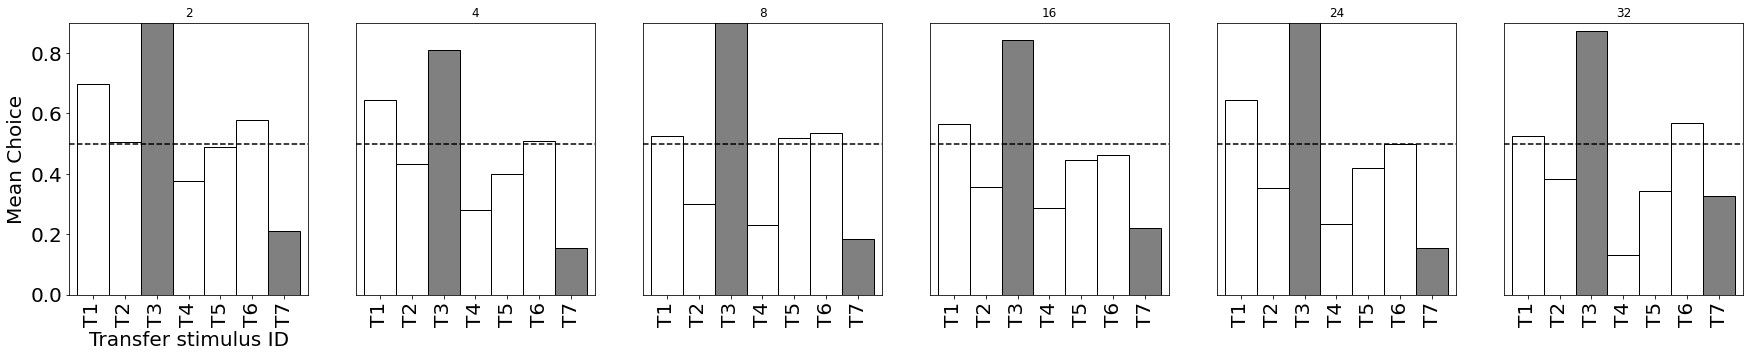

In [181]:
# subselect stimulus_id whose values have letter 'T' in them 
transfer_stimulus_ids = data[data['stimulus_id'].str.contains('T')]['stimulus_id']
transfer_data = data[data['stimulus_id'].isin(transfer_stimulus_ids)]
# plot barplot of mean across choice column for each stimulus_id
# transfer_data.groupby('stimulus_id')['choice'].mean().plot(kind='bar')
# plt.xlabel('Stimulus ID', fontsize=FONTSIZE)
# plt.ylabel('Mean Choice', fontsize=FONTSIZE)
# plt.xticks(fontsize=FONTSIZE)
# plt.yticks(fontsize=FONTSIZE)
# plt.show() 
# repeat the above plot for each unique values in the task_feature column of the transfer_data dataframe
# the barplot for each task_feature should be plotted in a separate subplot
fig, ax = plt.subplots(1, len(transfer_data['task_feature'].unique()), figsize=(5*len(transfer_data['task_feature'].unique()), 5))
for i, task_feature in enumerate(transfer_data['task_feature'].unique()):
    # remove the spacing between bars in the bar plot
    (1-transfer_data[transfer_data['task_feature'] == task_feature].groupby('stimulus_id')['choice'].mean()).plot(kind='bar', ax=ax[i], width=1., edgecolor='black', linewidth=1, color='white')
    # color the third and seventh bar in the bar plot gray
    ax[i].patches[2].set_facecolor('gray')
    ax[i].patches[6].set_facecolor('gray')
    ax[i].set_title(task_feature)
    # set ylim to be the same for all subplots
    ax[i].set_ylim([0, 0.9])#1.05
    # draw a horizontal line at y=0.5
    ax[i].axhline(y=0.5, linestyle='--', color='black')
    if i==0:
        ax[i].set_xlabel('Transfer stimulus ID', fontsize=FONTSIZE)
        ax[i].set_ylabel('Mean Choice', fontsize=FONTSIZE)
        ax[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    else:
        # only xticks
        ax[i].tick_params(axis='x', which='major', labelsize=FONTSIZE)
        #remove yticks
        ax[i].set_yticks([])
        # remove xlabel and ylabel
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')





In [209]:
num_repeats= 10
num_samples = 10000
abbba_count = np.zeros((num_repeats, len(transfer_data['task_feature'].unique())))
aabbb_count = np.zeros((num_repeats, len(transfer_data['task_feature'].unique())))
bbaba_count = np.zeros((num_repeats, len(transfer_data['task_feature'].unique())))
for j in range(num_repeats):
    for i, task_feature in enumerate(transfer_data['task_feature'].unique()):
        # remove the spacing between bars in the bar plot
        probs_all_transfer = (1-transfer_data[transfer_data['task_feature'] == task_feature].groupby('stimulus_id')['choice'].mean()).values
        ## keep all values except the third and seventh value
        probs_all_transfer = np.delete(probs_all_transfer, [2, 6])
        # sample from each probability value in probs_all_transfer 1000 times using bernoulli distribution
        sample_transfer_items = np.random.binomial(1, probs_all_transfer, size=(num_samples, len(probs_all_transfer)))
        # count the number of unique rows in sample_transfer_items
        unique, counts = np.unique(sample_transfer_items, axis=0, return_counts=True)
        # find the counts for [1, 0, 0, 0, 1]
        counts_abbba = counts[np.where((unique[:, 0]==1) & (unique[:, 4]==1) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==0))]
        # add all counts for those which differed from [1, 0, 0, 0, 1] in only one position
        counts_abbba += counts[np.where((unique[:, 0]==0) & (unique[:, 4]==1) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==0))]
        counts_abbba += counts[np.where((unique[:, 0]==1) & (unique[:, 4]==0) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==0))]
        counts_abbba += counts[np.where((unique[:, 0]==1) & (unique[:, 4]==1) & (unique[:, 1]==1) & (unique[:, 2]==0) & (unique[:, 3]==0))]
        counts_abbba += counts[np.where((unique[:, 0]==1) & (unique[:, 4]==1) & (unique[:, 1]==0) & (unique[:, 2]==1) & (unique[:, 3]==0))]
        counts_abbba += counts[np.where((unique[:, 0]==1) & (unique[:, 4]==1) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==1))]
        # find the counts for [1, 1, 0, 0, 0]
        counts_aabbb = counts[np.where((unique[:, 0]==1) & (unique[:, 1]==1) & (unique[:, 2]==0) & (unique[:, 3]==0) & (unique[:, 4]==0))]
        # add all counts for those which differed from [1, 1, 0, 0, 0] in only one position
        counts_aabbb += counts[np.where((unique[:, 0]==0) & (unique[:, 1]==1) & (unique[:, 2]==0) & (unique[:, 3]==0) & (unique[:, 4]==0))]
        counts_aabbb += counts[np.where((unique[:, 0]==1) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==0) & (unique[:, 4]==0))]
        counts_aabbb += counts[np.where((unique[:, 0]==1) & (unique[:, 1]==1) & (unique[:, 2]==1) & (unique[:, 3]==0) & (unique[:, 4]==0))]
        counts_aabbb += counts[np.where((unique[:, 0]==1) & (unique[:, 1]==1) & (unique[:, 2]==0) & (unique[:, 3]==1) & (unique[:, 4]==0))]
        counts_aabbb += counts[np.where((unique[:, 0]==1) & (unique[:, 1]==1) & (unique[:, 2]==0) & (unique[:, 3]==0) & (unique[:, 4]==1))]
        # find the counts for [0, 0, 1, 0, 1]
        counts_bbaba = counts[np.where((unique[:, 0]==0) & (unique[:, 1]==0) & (unique[:, 2]==1) & (unique[:, 3]==0) & (unique[:, 4]==1))]
        # add all counts for those which differed from [0, 0, 1, 0, 1] in only one position
        counts_bbaba += counts[np.where((unique[:, 0]==1) & (unique[:, 1]==0) & (unique[:, 2]==1) & (unique[:, 3]==0) & (unique[:, 4]==1))]
        counts_bbaba += counts[np.where((unique[:, 0]==0) & (unique[:, 1]==1) & (unique[:, 2]==1) & (unique[:, 3]==0) & (unique[:, 4]==1))]
        counts_bbaba += counts[np.where((unique[:, 0]==0) & (unique[:, 1]==0) & (unique[:, 2]==0) & (unique[:, 3]==0) & (unique[:, 4]==1))]
        counts_bbaba += counts[np.where((unique[:, 0]==0) & (unique[:, 1]==0) & (unique[:, 2]==1) & (unique[:, 3]==1) & (unique[:, 4]==1))]
        counts_bbaba += counts[np.where((unique[:, 0]==0) & (unique[:, 1]==0) & (unique[:, 2]==1) & (unique[:, 3]==0) & (unique[:, 4]==0))]
        # append the counts for each task_feature to the respective lists
        abbba_count[j, i] = (counts_abbba/num_samples)
        aabbb_count[j, i] = (counts_aabbb/num_samples)
        bbaba_count[j, i] = (counts_bbaba/num_samples)


    

In [210]:
abbba_count.mean(axis=0)

array([0.30338, 0.34877, 0.33618, 0.31191, 0.38319, 0.41525])

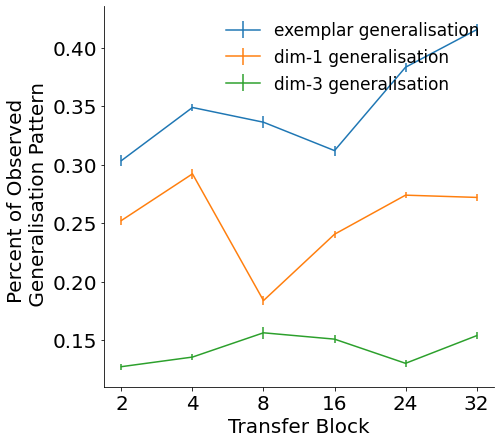

In [219]:
# plot the counts of abbba, aabbb and bbaba across task_features as a line plot in a single subplot
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.plot(abbba_count.mean(axis=0), label='exemplar generalisation')
ax.errorbar(np.arange(0, len(transfer_data['task_feature'].unique())), abbba_count.mean(axis=0), yerr=abbba_count.std(axis=0), label='exemplar generalisation')
# ax.plot(aabbb_count.mean(axis=0), label='dim-1 generalisation')
ax.errorbar(np.arange(0, len(transfer_data['task_feature'].unique())), aabbb_count.mean(axis=0), yerr=aabbb_count.std(axis=0), label='dim-1 generalisation')
# ax.plot(bbaba_count.mean(axis=0), label='dim-3 generalisation')
ax.errorbar(np.arange(0, len(transfer_data['task_feature'].unique())), bbaba_count.mean(axis=0), yerr=bbaba_count.std(axis=0), label='dim-3 generalisation')
ax.set_xlabel('Transfer Block', fontsize=FONTSIZE)
ax.set_ylabel('Percent of Observed \n Generalisation Pattern', fontsize=FONTSIZE)
ax.set_xticks(np.arange(0, len(transfer_data['task_feature'].unique())))
ax.set_xticklabels(transfer_data['task_feature'].unique())
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE-3, loc='upper right', frameon=False)
sns.despine()
plt.show()


In [60]:
new_df = transfer_data[transfer_data['task_feature'] == 2]
# made a df that has all the unique stimulus_id as columns and choice values made for a each stimulus_id in the rows
new_df = new_df.pivot(index='stimulus_id', columns='task', values='choice')
new_df


task,0,1,2,3,4,5,6,7,8,9,...,670,671,672,673,674,675,676,677,678,679
stimulus_id,,,,,,,,,,,,,,,,,,,,,
T1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
T3,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
T4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T5,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
T6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
T7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN


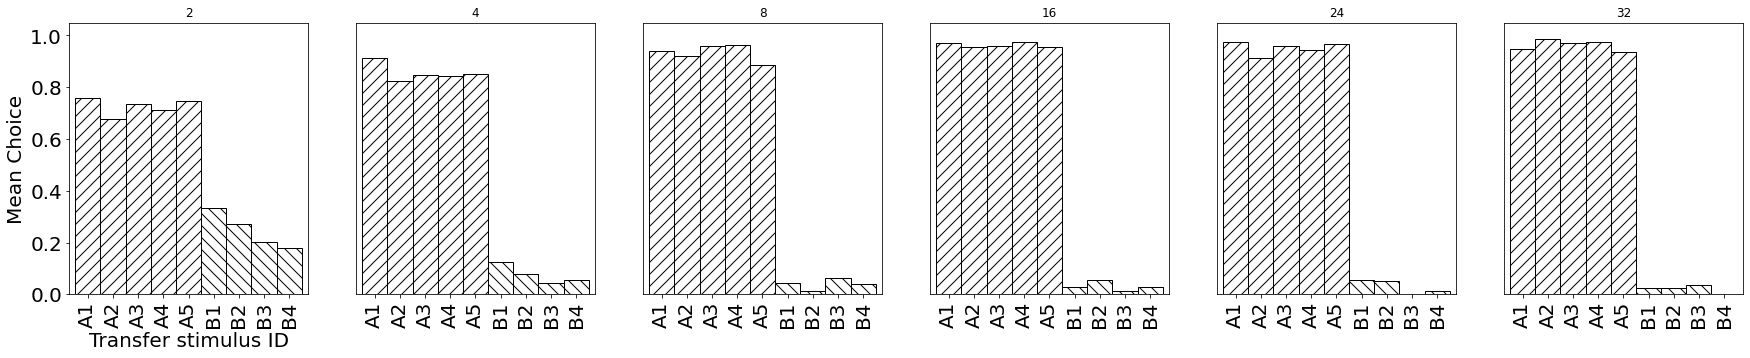

In [42]:
# keep only stimulus_id starting with 'A' and 'B'
train_data = data[data['stimulus_id'].str.contains('A|B')]
# group data by task feature and task
train_data = train_data.groupby(['task_feature', 'task']).tail(1)

fig, ax = plt.subplots(1, len(transfer_data['task_feature'].unique()), figsize=(5*len(transfer_data['task_feature'].unique()), 5))
for i, task_feature in enumerate(transfer_data['task_feature'].unique()):
    # remove the spacing between bars in the bar plot with hash pattern
    (1-train_data[train_data['task_feature'] == task_feature].groupby('stimulus_id')['choice'].mean()).plot(kind='bar', ax=ax[i], width=1., edgecolor='black', linewidth=1, color='white', hatch='//')
    ax[i].set_title(task_feature)
    # reverse hash pattern for last four bars
    [ax[i].patches[ii].set_hatch('\\\\') for ii in range(5, 9)]
    # set ylim to be the same for all subplots
    ax[i].set_ylim([0, 1.05])
    if i==0:
        ax[i].set_xlabel('Transfer stimulus ID', fontsize=FONTSIZE)
        ax[i].set_ylabel('Mean Choice', fontsize=FONTSIZE)
        ax[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    else:
        # only xticks
        ax[i].tick_params(axis='x', which='major', labelsize=FONTSIZE)
        #remove yticks
        ax[i].set_yticks([])
        # remove xlabel and ylabel
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

plt.show()


## Other tasks 

In [ ]:
from plots import metalearner_nosofskys_task
metalearner_nosofskys_task(experiment=2, noises=[0.0], shuffles=[True], num_runs=50, num_blocks=1, num_eval_tasks=64)

In [ ]:
from plots import compare_metalearners
compare_metalearners(tasks=np.arange(1,7), noises=[0.0], shuffles=[True], shuffle_evals=[False], experiment='shepard_categorisation', num_runs=50, num_eval_tasks=64)

In [ ]:
from plots import metalearner_leverings_task
metalearner_leverings_task(noises=[0.0], shuffles=[True], num_runs=50, num_eval_tasks=64, num_trials=150)

# Test meta-learner for different categorisation effects

### Levering et al. 2019: linear vs non-linear decision boundary

In [ ]:
from plots import metalearner_leverings_task
metalearner_leverings_task(shuffles=[True], num_runs=20, num_eval_tasks=64, num_trials=150)

#### conditions

In [ ]:
from envs import LeveringsTask
levs_task = LeveringsTask(task='nonlinear')#, batch_size=1, num_blocks=1)
a, b, c = levs_task.sample_batch()

In [ ]:
a[0, :6, :3], c[0][:6]

### Nosofsky 1998: Base-rate effects

In [ ]:
from plots import metalearner_nosofskys_task
metalearner_nosofskys_task(experiment=2, noises=[0.0], shuffles=[True], num_runs=50, num_blocks=1, num_eval_tasks=64)

#### conditions

In [ ]:
from envs import NosofskysTask
nosofs_task = NosofskysTask(task=[4, 1, 5], batch_size=3)
a, b, c = nosofs_task.sample_batch()

#### Replication of figure

In [ ]:
from envs import NosofskysTask
nosofs_task = NosofskysTask(task=[4, None, None], batch_size=1)
a, b, c = nosofs_task.sample_batch()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(a[:, c[0].squeeze()==0, 1], a[:, c[0].squeeze()==0, 0])
ax.scatter(a[:, c[0].squeeze()==1, 1], a[:, c[0].squeeze()==1, 0])
ax.set_xlabel('Saturation', fontsize=FONTSIZE-2)
ax.set_ylabel('Brightness', fontsize=FONTSIZE-2)
plt.show()

### Shepard et al. 1961: Learning trends

In [ ]:
from plots import compare_metalearners
compare_metalearners(tasks=np.arange(1,7), noises=[0.0], shuffles=[True], shuffle_evals=[False], experiment='shepard_categorisation', num_runs=10, num_eval_tasks=32)#shepard_categorisation

# Compare meta-learning models

In [ ]:
from plots import compare_metalearners

In [ ]:
compare_metalearners(num_runs=5)

# Evaluate meta-learner on validation task

In [ ]:
noise=0.1
shuffle=False
shuffle_eval=False

In [ ]:
env_name='/raven/u/ajagadish/vanilla-llama/categorisation/data/claude_generated_tasks_paramsNA_dim3_data100_tasks14000.csv'
model_path=f"/raven/u/ajagadish/vanilla-llama/categorisation/trained_models/env=claude_generated_tasks_paramsNA_dim3_data100_tasks14000_num_episodes500000_num_hidden=128_lr0.0003_noise{noise}_shuffle{shuffle}_run=0.pt"

### model and training class distribution in eval

In [ ]:
num_runs=10

In [ ]:
for run_idx in range(num_runs):
    _, model_choices, true_choices, sequences = evaluate_1d(env_name=env_name, \
                      model_path=model_path, \
                      mode='val', return_all=True, shuffle_trials=shuffle_eval)
    cum_sum = np.array(sequences).cumsum()
    pooled_model_choices = np.ones((num_runs, len(cum_sum), np.diff(cum_sum).max())) if run_idx==0 else pooled_model_choices
    pooled_true_choices = np.ones((num_runs, len(cum_sum), np.diff(cum_sum).max())) if run_idx==0 else pooled_true_choices
    model_choices = model_choices.round()
    for task_idx, seq in enumerate(cum_sum[:-1]):
        task_correct = (model_choices==true_choices)[cum_sum[task_idx]:cum_sum[task_idx+1]]
        pooled_model_choices[run_idx, task_idx,:(cum_sum[task_idx+1]-cum_sum[task_idx])] = model_choices[cum_sum[task_idx]:cum_sum[task_idx+1]]
        pooled_true_choices[run_idx, task_idx,:(cum_sum[task_idx+1]-cum_sum[task_idx])] = true_choices[cum_sum[task_idx]:cum_sum[task_idx+1]]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pooled_true_choices.mean(0).mean(0)[:50])
plt.plot(pooled_model_choices.mean(0).mean(0)[:50])
plt.title("Class distribution within the dataset", fontsize=16)
plt.xlabel("Trial", fontsize=14)
plt.ylabel("Mean class", fontsize=14)
plt.show()

### evaluate an example model on left-out tasks

In [ ]:
from plots import metalearner_evaluation
metalearner_evaluation(env_name, model_path, shuffle_trials=shuffle_eval, num_runs=10)

# Evaluate meta-learner on Badham et al. 2017 task

In [ ]:
dat = pd.read_csv('../data/human/exp1.csv')
model = torch.load(model_path)[1]
dat['shifted_category'] = np.concatenate((np.array([0.]), dat['category'].values[:-1]))
participants = dat.participant.unique()
conditions = dat.condition.unique()
performance = np.zeros((len(conditions), len(participants)))
per_trial_performance = np.ones((len(conditions), len(participants), 96))
inputs = []
for idx1, cond in enumerate(conditions):
    for idx2, participant in enumerate(participants):
        CONDITION = cond #4
        PARTICIPANT = participant #0
        ## order of features matched to what llm generated order
        inputs = dat[dat.participant==PARTICIPANT][dat.condition==CONDITION][['feature3','feature1','feature2', 'shifted_category']].values #shifted_category
        targets = dat[dat.participant==PARTICIPANT][dat.condition==CONDITION]['category'].values

        inputs = [torch.from_numpy(inputs)]
        packed_inputs = rnn_utils.pad_sequence(inputs, batch_first=True)
        sequence_lengths = [len(x) for x in inputs]

        with torch.no_grad():
            model.eval()
            model_choices = model(packed_inputs, sequence_lengths)
            true_choices = targets.astype(float)
            model_choices = model_choices.view(-1).float().round()
            #print(true_choices.shape, model_choices.shape)
            per_trial_performance[idx1, idx2, :sequence_lengths[0]] = torch.eq(torch.tensor(true_choices), model_choices)
            accuracy = torch.eq(torch.tensor(true_choices), model_choices).sum()/len(model_choices)
        performance[idx1, idx2] = accuracy

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(conditions,  performance.mean(1), yerr= performance.std(1), tick_label=["Type ONE", "Type TWO", "Type THREE", "Type FOUR"])
plt.title("Meta-Learner's performance", fontsize=16)
plt.xlabel("Task Type", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(1-per_trial_performance.mean(1).T,  label=["Type ONE", "Type TWO", "Type THREE", "Type FOUR"])
plt.title("Meta-Learner's performance", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()